In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# TensorFlow/Keras (Keras layers and optimizers below)
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

# sklearn
from sklearn.model_selection import KFold

# Custom
import sys
sys.path.insert(0, '../src/utils')
# from trace_handler import TraceHandler
from data_loader import DataLoader
import constants
# from single_byte_evaluator import SingleByteEvaluator
sys.path.insert(0, '../src/modeling')
from network import Network
from evaluator import Evaluator

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
BYTE_IDX = 0
# N_CLASSES = 256 ############# look at to_categorical of DataLoader if something goes wrong

train_dl = DataLoader('/prj/side_channel/PinataTraces/datasets/SBOX_OUT/D1-K1.json', BYTE_IDX)
# train_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs')    

x_train, y_train = train_dl.get_train() # Default 80% train (40,000 train traces)


# x_train_tot = train_th.get_traces()
# y_train_tot = train_th.get_specific_labels(BYTE_IDX)
# y_train_tot = to_categorical(y_train_tot, N_CLASSES)

# # Test
# test_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs')

# x_test, y_test = test_th.generate_test(BYTE_IDX) 
# y_test = to_categorical(y_test, N_CLASSES)

# test_plaintexts = test_th.get_plaintexts()
# true_key_byte = test_th.get_key()[BYTE_IDX]

Loading the dataset... 
Dataset successfully loaded in 7.90 seconds.


In [3]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

HP_CHOICES = {#'kernel_initializer': ['random_normal', 'random_uniform', 
              #                       'truncated_normal', 
              #                       'zeros', 'ones', 
              #                       'glorot_normal', 'glorot_uniform',
              #                       'he_normal', 'he_uniform',
              #                       'identity', 'orthogonal', 'constant', 'variance_scaling'],
              'kernel_initializer': ['random_normal', 'random_uniform', 'truncated_normal', 'he_normal', 'he_uniform'],  
              'activation':         ['relu', 'tanh'],
              'hidden_layers':      [1, 2, 3, 4, 5, 6],
              'hidden_neurons':     [100, 200, 300, 400, 500, 600],
              'dropout_rate':       [0.0, 0.2, 0.4],
              'optimizer':          [SGD, Adam, RMSprop],
              'learning_rate':      [1e-3, 1e-4, 1e-5, 1e-6],
              'batch_size':         [50, 100, 200, 500, 1000]}    

def build_model(hp):
    model = Sequential()
    
    # Input
    model.add(Dense(constants.TRACE_LEN,
                    kernel_initializer=hp['kernel_initializer'],
                    activation=hp['activation']))

    # First BatchNorm
    model.add(BatchNormalization())

    # Hidden
    for _ in range(hp['hidden_layers']):
        model.add(Dense(hp['hidden_neurons'],
                        kernel_initializer=hp['kernel_initializer'],
                        activation=hp['activation']))

        # Dropout
        model.add(Dropout(hp['dropout_rate']))

    # Second BatchNorm
    model.add(BatchNormalization())

    # Output
    model.add(Dense(256, activation='softmax')) ########################### 256 to be changed if the target is changed (HW, ...)

    # Compilation
    model.compile(optimizer=hp['optimizer'](learning_rate=hp['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [4]:
N_MODELS = 20

models = []
for _ in range(N_MODELS):
    
    chosen_hp = {k: random.choice(HP_CHOICES[k]) for k in HP_CHOICES} 
    
    model = build_model(chosen_hp)
    models.append((model, chosen_hp))

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', 
                               patience=12))
callbacks.append(ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=5,
                                   min_lr=1e-7))

In [6]:
N_EXP = 10
EPOCHS = 300

METRIC = 'ACC'

kf = KFold(n_splits=N_EXP)

results = [] # list of tuples (model_id, model_avg_val_loss, model_history)
for m, model in enumerate(models):
    print(f'------------------------------ Model {m+1}/{N_MODELS} ------------------------------')
    
    net, net_hp = model
    
    net_metric = []
    net_histories = []
    for e, indices in tqdm(enumerate(kf.split(x_train))):
        
        train_indices, val_indices = indices
        
        x_t = x_train[train_indices]
        y_t = y_train[train_indices]
        
        x_v = x_train[val_indices]
        y_v = y_train[val_indices]
        
        history = net.fit(x_t, 
                          y_t,
                          validation_data=(x_v, y_v),
                          epochs=EPOCHS,
                          batch_size=net_hp['batch_size'],
                          callbacks=callbacks,
                          verbose=0)
        
        val_loss, val_acc = net.evaluate(x_v, y_v, verbose=0)
        
        if METRIC == 'LOSS':
            metric = val_loss
        else:
            metric = val_acc
            
        net_metric.append(metric)
        net_histories.append(history)
    
    net_metric = np.array(net_metric)
    net_avg_metric = np.mean(net_metric)
    
    results.append((m, net_avg_metric, net_histories))
    
    print(f'Avg {METRIC}: {net_avg_metric}')
    print()

------------------------------ Model 1/1 ------------------------------


10it [00:29,  2.96s/it]

Avg ACC: 0.004499999899417162



In [7]:
rev = True

if METRIC == 'LOSS':
    rev = False
    
results.sort(key=lambda x: x[1], reverse=rev)
print()
print(f'K-Fold Crossvalidation Results: {[(idx, loss) for idx, loss, _ in results]}')


K-Fold Crossvalidation Results: [(0, 0.004499999899417162)]


In [8]:
best_net, best_net_hp = models[results[0][0]]
best_net_histories = results[0][2]

In [9]:
best_net_hp

{'kernel_initializer': 'he_uniform',
 'activation': 'tanh',
 'hidden_layers': 3,
 'hidden_neurons': 400,
 'dropout_rate': 0.0,
 'optimizer': keras.optimizer_v2.gradient_descent.SGD,
 'learning_rate': 1e-05,
 'batch_size': 1000}

In [10]:
from evaluator import Evaluator

ges = []

for i, device in enumerate(constants.DEVICES):
    for j, key in enumerate(constants.KEYS):
        
        print(f'----- {device}-{key} -----')
        
        if device == 'D1' and key == 'K1':
            path = '/prj/side_channel/PinataTraces/datasets/SBOX_OUT/D1-K1.json'
        else:
            path = f'/prj/side_channel/PinataTraces/datasets/SBOX_OUT/{device}-{key}.json'

        test_dl = DataLoader(path, BYTE_IDX)
        x_test, y_test, pltxt_test = test_dl.get_test()
        true_key_byte = test_dl.get_true_key_byte()
        
        evaluator = Evaluator(x_test, pltxt_test, true_key_byte, 'MLP')

        ge = evaluator.guessing_entropy(n_exp=10,
                                        hp=best_net_hp,
                                        x_train=x_train,
                                        y_train=y_train,
                                        epochs=200)
        
        ges.append(ge)
        
        print()

ges = np.array(ges)

----- D1-K1 -----
Loading the dataset... 
Dataset successfully loaded in 7.87 seconds.


Computing GE: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]



----- D1-K2 -----
Loading the dataset... 
Dataset successfully loaded in 55.17 seconds.


Computing GE: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]



----- D1-K3 -----
Loading the dataset... 
Dataset successfully loaded in 55.98 seconds.


Computing GE: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]



----- D2-K1 -----
Loading the dataset... 
Dataset successfully loaded in 55.00 seconds.


Computing GE: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]



----- D2-K2 -----
Loading the dataset... 
Dataset successfully loaded in 54.97 seconds.


Computing GE: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]



----- D2-K3 -----
Loading the dataset... 
Dataset successfully loaded in 55.02 seconds.


Computing GE: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

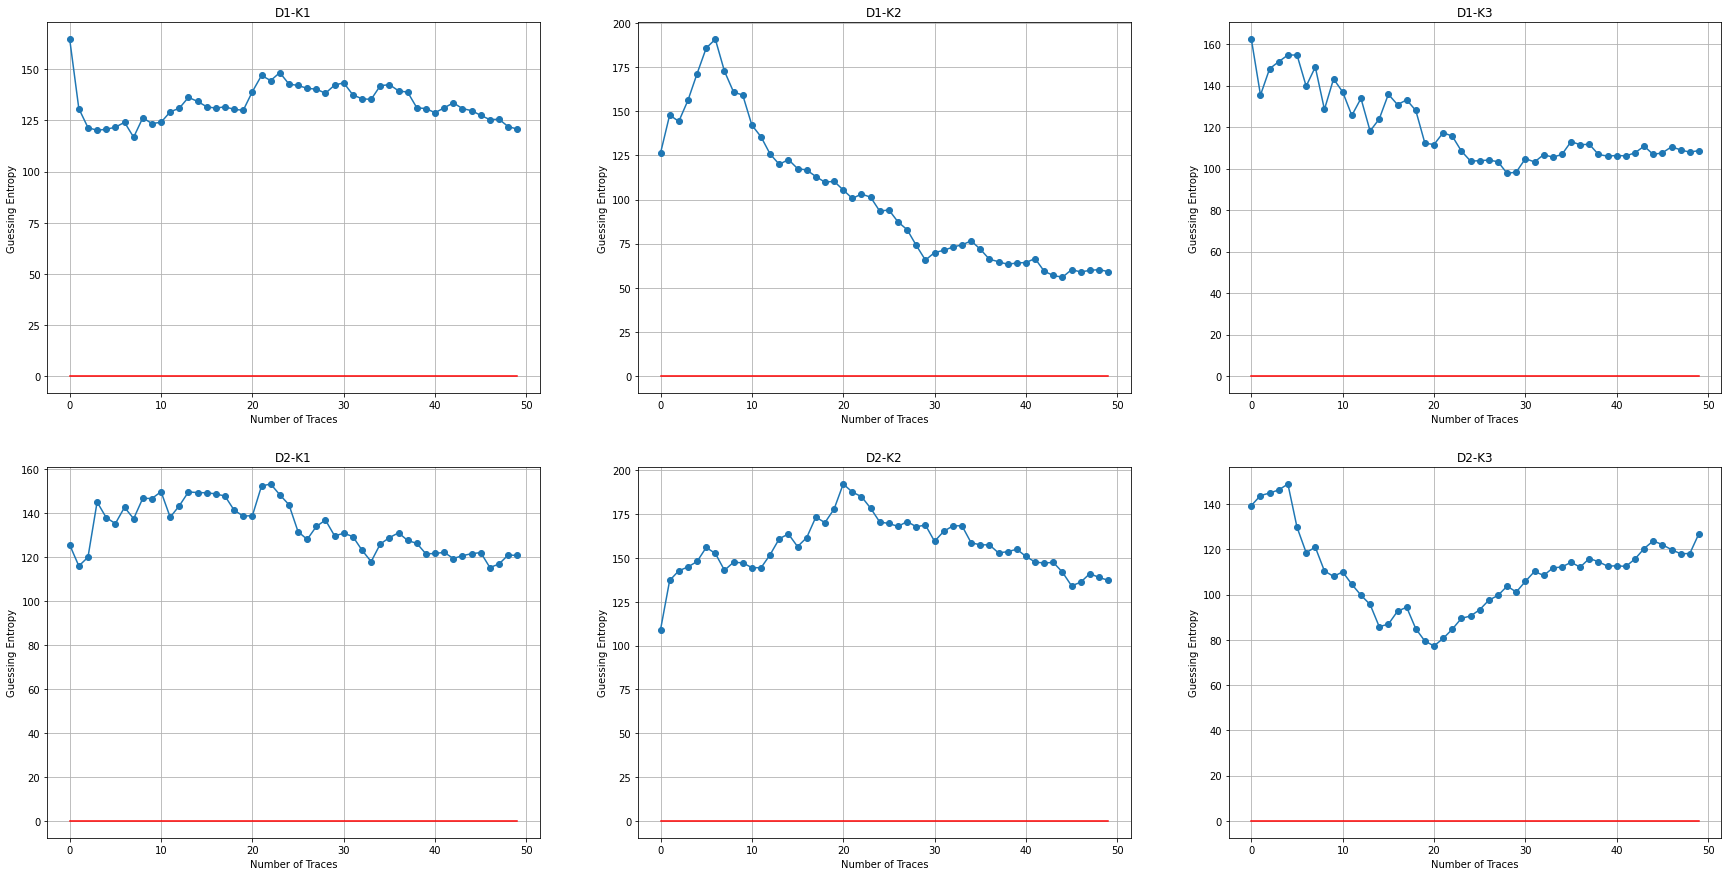

In [16]:
N = 50

f, ax = plt.subplots(len(constants.DEVICES), len(constants.KEYS), figsize=(30,15))

row = 0
for i, ge in enumerate(ges):
    
    col = i % 3
    
    ax[row, col].plot(ge[:N], marker='o')
    ax[row, col].set_title(f'D{row+1}-K{col+1}')
    ax[row, col].set_xlabel('Number of Traces')
    ax[row, col].set_ylabel('Guessing Entropy')
    ax[row, col].plot(np.zeros(N), color='r')
    ax[row, col].grid()
    # _ = ax[row, col].set_xticks(range(N))
    
    if col == 2:
        row += 1

plt.show()

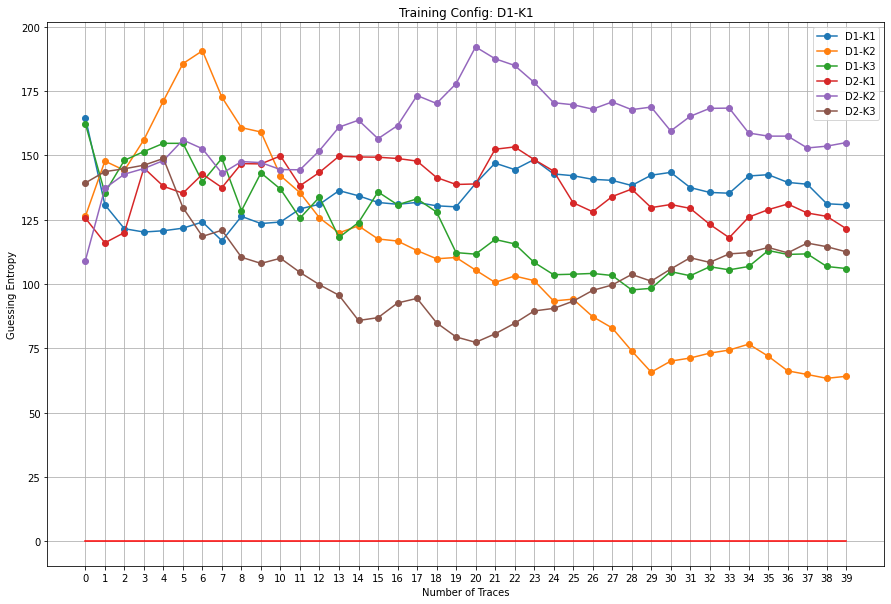

In [18]:
N = 40

f, ax = plt.subplots(figsize=(15,10))

device = 1
for i, ge in enumerate(ges):
    
    key = i % 3
    
    ax.plot(ge[:N], marker='o', label=f'D{device}-K{key+1}')
    ax.set_title('Training Config: D1-K1')
    ax.set_xlabel('Number of Traces')
    ax.set_ylabel('Guessing Entropy')
    ax.grid()
    _ = ax.set_xticks(range(N))
    
    if key == 2:
        device += 1

plt.plot(np.zeros(N), color='r')
plt.grid()
plt.legend()
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15,10))

device = 1
for i, ge in enumerate(ges):
    
    key = i % 3
    
    ax.plot(ge, label=f'D{device}-K{key+1}')
    ax.set_title('Training Config: D1-K1')
    ax.set_xlabel('Number of Traces')
    ax.set_ylabel('Guessing Entropy')
    ax.grid()
    
    if key == 2:
        device += 1

        plt.plot(np.zeros(N), color='r')
plt.grid()
plt.legend()
plt.show()